In [1]:
import json

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Plain & Residual Block 생성기

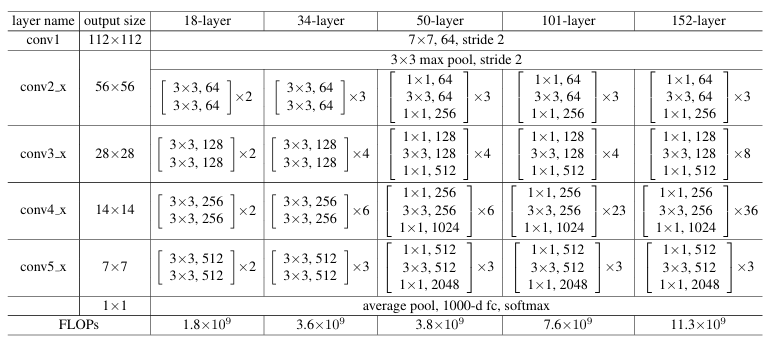

In [3]:
def build_plain_block(input_layer,
                      filter_sizes = [3, 3],
                      channels=[64, 64],
                      loof_num =1,
                      block_num=1,
                      resd_num = 1,
                      residual = False,
                     ):
    
    # 입력 레이어
    x = input_layer
    identity = x
    
    # CNN 레이어
    for cnn_num, (filter_size, channel) in enumerate(zip(filter_sizes, channels)):
        if block_num in [3, 4, 5]:
            if loof_num + cnn_num == 0:
                stride_num = 2
            else :
                stride_num = 1
        else :
            stride_num = 1
            
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(filter_size,filter_size),
            strides=stride_num,
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{loof_num + cnn_num + 1}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        if cnn_num != len(filter_sizes):
            x = keras.layers.Activation('relu')(x)
        
    if residual:
        if block_num in [3, 4, 5]:
            stride_num = 2
            if loof_num == 0:
                stride_num = 2
            else:
                stride_num = 1
        else :
            stride_num = 1
            
        identity = keras.layers.Conv2D(
            filters=channels[-1],
            kernel_size=(1,1),
            strides=stride_num,
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_linear_projection{resd_num}'
        )(identity)
        
        if block_num in [3, 4, 5]:
            if loof_num == 0:
                identity = keras.layers.BatchNormalization(name=f'block{block_num}_barch_shout{resd_num}')(identity)
        
        x = keras.layers.Add(name=f'block{block_num}_residual{resd_num}')([x,identity])
        x = keras.layers.Activation('relu')(x)
    
    return x

In [4]:
def build_res(input_shape=(32,32,3),
              num_cnn_list = [3, 4, 6, 3],
              filter_sizes_list=[[3, 3],[3, 3],[3, 3],[3, 3]],
              channel_list=[[64, 64],[128, 128],[256, 256],[512,512]],
              residual=False,):
    
    assert len(num_cnn_list) == len(channel_list) == len(filter_sizes_list)
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        activation=None,
        kernel_initializer='he_normal',
        padding='same',
        name='block1_conv1'
    )(output)
    
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding="same",
        name='block1_maxpooling1',
    )(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for idx, (num_cnn, filter_size, channel) in enumerate(zip(num_cnn_list, filter_sizes_list, channel_list)):
        for k in range(num_cnn):
            output = build_plain_block(
                output,
                filter_sizes=filter_size,
                channels=channel,
                loof_num = k*len(filter_size),
                block_num=idx+2,
                resd_num = k+1,
                residual=residual,
            )
        
    output = keras.layers.AveragePooling2D(padding='same',name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(1, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

# 각 모델 생성

In [5]:
plain_34 = build_res(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],
    filter_sizes_list=[[3, 3],[3, 3],[3, 3],[3, 3]],
    channel_list=[[64, 64],[128, 128],[256, 256],[512,512]],
    residual=False,
    )

plain_34.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
block1_maxpooling1 (MaxPooli (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256   

In [6]:
resnet_34 = build_res(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],
    filter_sizes_list=[[3, 3],[3, 3],[3, 3],[3, 3]],
    channel_list=[[64, 64],[128, 128],[256, 256],[512,512]],
    residual=True,
    )

resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_33[0][0]     
____________________________________________________________________________________________

In [7]:
plain_50 = build_res(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],
    filter_sizes_list=[[1, 3, 1],[1, 3, 1],[1, 3, 1],[1, 3, 1]],
    channel_list=[[64, 64, 256],[128, 128, 512],[256, 256, 1024],[512,512, 2048]],
    residual=False,
    )

plain_50.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_66 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
block1_maxpooling1 (MaxPooli (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_67 (Batc (None, 56, 56, 64)        256 

In [8]:
resnet_50 = build_res(
    input_shape=(224,224,3),
    num_cnn_list=[3,4,6,3],
    filter_sizes_list=[[1, 3, 1],[1, 3, 1],[1, 3, 1],[1, 3, 1]],
    channel_list=[[64, 64, 256],[128, 128, 512],[256, 256, 1024],[512,512, 2048]],
    residual=True,
    )

resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_131 (Activation)     (None, 112, 112, 64) 0           batch_normalization_115[0][0]    
____________________________________________________________________________________________

# 데이터 import 및 전처리

In [9]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL'," https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip ")

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [11]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [12]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [13]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [15]:
BATCH_SIZE = 32
EPOCH = 20

In [16]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 모델 구동

In [17]:
#resnet_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#history = resnet_50.fit(
    #ds_train,
    #epochs=EPOCH,
    #steps_per_epoch=int(18610/BATCH_SIZE),
    #validation_steps=int(4652/BATCH_SIZE),
    #validation_data=ds_test,
    #verbose=1,
    #use_multiprocessing=True,)

In [19]:
#with open('history/history_resnet_50.json', 'w') as f:
    #json.dump(history.history, f)

In [20]:
#del resnet_50

In [21]:
plain_50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_plain_50 = plain_50.fit(
    ds_train,
    epochs=EPOCH,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 21/581 [>.............................] - ETA: 2:19 - loss: 1.3565 - accuracy: 0.4866

 36/581 [>.............................] - ETA: 2:15 - loss: 1.1638 - accuracy: 0.4931

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 1:57 - loss: 1.0606 - accuracy: 0.5146

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 1:06 - loss: 1.0087 - accuracy: 0.5122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 1:03 - loss: 1.0125 - accuracy: 0.5097

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:00 - loss: 1.0094 - accuracy: 0.5107

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


367/581 [=================>............] - ETA: 53s - loss: 1.0029 - accuracy: 0.5099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 52s - loss: 0.9992 - accuracy: 0.5090

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


574/581 [============================>.] - ETA: 1s - loss: 0.9214 - accuracy: 0.5093

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.5094

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 227s 287ms/step - loss: 0.9188 - accuracy: 0.5094 - val_loss: 0.7365 - val_accuracy: 0.5241
Epoch 2/20
 28/581 [>.............................] - ETA: 2:22 - loss: 0.7493 - accuracy: 0.4967

 39/581 [=>............................] - ETA: 2:19 - loss: 0.7492 - accuracy: 0.4912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 2:00 - loss: 0.7319 - accuracy: 0.5155

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 1:09 - loss: 0.7284 - accuracy: 0.5122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:06 - loss: 0.7273 - accuracy: 0.5117

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:02 - loss: 0.7265 - accuracy: 0.5115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 55s - loss: 0.7260 - accuracy: 0.5110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 53s - loss: 0.7255 - accuracy: 0.5111

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


571/581 [============================>.] - ETA: 2s - loss: 0.7195 - accuracy: 0.5176

581/581 [==============================] - ETA: 0s - loss: 0.7196 - accuracy: 0.5175

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 290ms/step - loss: 0.7196 - accuracy: 0.5175 - val_loss: 0.6904 - val_accuracy: 0.5254
Epoch 3/20
  3/581 [..............................] - ETA: 2:30 - loss: 0.6857 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 2:20 - loss: 0.6917 - accuracy: 0.5473

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:01 - loss: 0.6928 - accuracy: 0.5619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 1:08 - loss: 0.7032 - accuracy: 0.5333

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:05 - loss: 0.7032 - accuracy: 0.5316

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:01 - loss: 0.7029 - accuracy: 0.5324

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 54s - loss: 0.7052 - accuracy: 0.5329

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 52s - loss: 0.7077 - accuracy: 0.5338

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 1s - loss: 0.7077 - accuracy: 0.5354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.5347

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 290ms/step - loss: 0.7077 - accuracy: 0.5347 - val_loss: 0.6940 - val_accuracy: 0.5141
Epoch 4/20
 28/581 [>.............................] - ETA: 2:24 - loss: 0.6935 - accuracy: 0.5324

 40/581 [=>............................] - ETA: 2:21 - loss: 0.6903 - accuracy: 0.5523

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:01 - loss: 0.6892 - accuracy: 0.5707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:08 - loss: 0.6751 - accuracy: 0.5975

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:05 - loss: 0.6739 - accuracy: 0.5995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:01 - loss: 0.6739 - accuracy: 0.6009

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 54s - loss: 0.6723 - accuracy: 0.6031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 53s - loss: 0.6725 - accuracy: 0.6032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6072

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.6072

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 290ms/step - loss: 0.6689 - accuracy: 0.6072 - val_loss: 0.8638 - val_accuracy: 0.5543
Epoch 5/20
 28/581 [>.............................] - ETA: 2:24 - loss: 0.6387 - accuracy: 0.6406

 41/581 [=>............................] - ETA: 2:21 - loss: 0.6440 - accuracy: 0.6380

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:02 - loss: 0.6761 - accuracy: 0.5798

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:07 - loss: 0.6797 - accuracy: 0.5800

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:04 - loss: 0.6808 - accuracy: 0.5801

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:02 - loss: 0.6817 - accuracy: 0.5788

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 54s - loss: 0.6838 - accuracy: 0.5777

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 53s - loss: 0.6838 - accuracy: 0.5773

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5680

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 0.6882 - accuracy: 0.5680 - val_loss: 0.6873 - val_accuracy: 0.5574
Epoch 6/20


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 2:23 - loss: 0.6814 - accuracy: 0.5614

 41/581 [=>............................] - ETA: 2:20 - loss: 0.6849 - accuracy: 0.5534

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:01 - loss: 0.6873 - accuracy: 0.5655

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:07 - loss: 0.6871 - accuracy: 0.5677

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:04 - loss: 0.6868 - accuracy: 0.5694

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:01 - loss: 0.6865 - accuracy: 0.5697

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 54s - loss: 0.6859 - accuracy: 0.5711

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 52s - loss: 0.6856 - accuracy: 0.5717

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.5811

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.5811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 0.6816 - accuracy: 0.5811 - val_loss: 0.9618 - val_accuracy: 0.5608
Epoch 7/20
 32/581 [>.............................] - ETA: 2:22 - loss: 0.6575 - accuracy: 0.6426

 43/581 [=>............................] - ETA: 2:19 - loss: 0.6631 - accuracy: 0.6323

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:00 - loss: 0.6647 - accuracy: 0.6202

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:07 - loss: 0.6583 - accuracy: 0.6222

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:03 - loss: 0.6579 - accuracy: 0.6232

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:00 - loss: 0.6578 - accuracy: 0.6226

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 53s - loss: 0.6574 - accuracy: 0.6226

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 0.6575 - accuracy: 0.6228

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6284

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 288ms/step - loss: 0.6510 - accuracy: 0.6284 - val_loss: 0.6978 - val_accuracy: 0.5886
Epoch 8/20
  3/581 [..............................] - ETA: 2:28 - loss: 0.6466 - accuracy: 0.6146

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 2:22 - loss: 0.6617 - accuracy: 0.6193

 43/581 [=>............................] - ETA: 2:20 - loss: 0.6589 - accuracy: 0.6279

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:00 - loss: 0.6475 - accuracy: 0.6327

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:07 - loss: 0.6391 - accuracy: 0.6400

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:03 - loss: 0.6390 - accuracy: 0.6398

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:00 - loss: 0.6397 - accuracy: 0.6392

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 53s - loss: 0.6398 - accuracy: 0.6381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 0.6393 - accuracy: 0.6389

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.6455

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 0.6332 - accuracy: 0.6455 - val_loss: 0.6854 - val_accuracy: 0.5948
Epoch 9/20
  2/581 [..............................] - ETA: 2:29 - loss: 0.6210 - accuracy: 0.6719

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 2:20 - loss: 0.6172 - accuracy: 0.6696

 42/581 [=>............................] - ETA: 2:18 - loss: 0.6162 - accuracy: 0.6684

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:00 - loss: 0.6171 - accuracy: 0.6624

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:06 - loss: 0.6108 - accuracy: 0.6694

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:03 - loss: 0.6099 - accuracy: 0.6707

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:00 - loss: 0.6092 - accuracy: 0.6711

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 53s - loss: 0.6076 - accuracy: 0.6726

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 51s - loss: 0.6077 - accuracy: 0.6724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.6800

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 290ms/step - loss: 0.5999 - accuracy: 0.6800 - val_loss: 0.8288 - val_accuracy: 0.5483
Epoch 10/20


  8/581 [..............................] - ETA: 2:28 - loss: 0.6071 - accuracy: 0.6641

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 48/581 [=>............................] - ETA: 2:18 - loss: 0.5871 - accuracy: 0.6979

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:00 - loss: 0.5896 - accuracy: 0.6931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:06 - loss: 0.5891 - accuracy: 0.6886

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:03 - loss: 0.5885 - accuracy: 0.6886

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 59s - loss: 0.5873 - accuracy: 0.6902 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 52s - loss: 0.5837 - accuracy: 0.6937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 51s - loss: 0.5834 - accuracy: 0.6946

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.6973

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 170s 292ms/step - loss: 0.5811 - accuracy: 0.6973 - val_loss: 1.2137 - val_accuracy: 0.5414
Epoch 11/20
  8/581 [..............................] - ETA: 2:29 - loss: 0.5863 - accuracy: 0.7266

 10/581 [..............................] - ETA: 2:28 - loss: 0.5795 - accuracy: 0.7312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 48/581 [=>............................] - ETA: 2:18 - loss: 0.5897 - accuracy: 0.6875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:00 - loss: 0.5968 - accuracy: 0.6825

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:06 - loss: 0.5912 - accuracy: 0.6868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:02 - loss: 0.5900 - accuracy: 0.6879

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 59s - loss: 0.5893 - accuracy: 0.6884

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 52s - loss: 0.5866 - accuracy: 0.6919

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 50s - loss: 0.5866 - accuracy: 0.6916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.7059

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 0.5712 - accuracy: 0.7059 - val_loss: 0.7043 - val_accuracy: 0.6305
Epoch 12/20
  2/581 [..............................] - ETA: 2:29 - loss: 0.5767 - accuracy: 0.7812

 12/581 [..............................] - ETA: 2:27 - loss: 0.5652 - accuracy: 0.7370

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 50/581 [=>............................] - ETA: 2:17 - loss: 0.5290 - accuracy: 0.7544

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:59 - loss: 0.5149 - accuracy: 0.7534

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:06 - loss: 0.5147 - accuracy: 0.7543

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:02 - loss: 0.5137 - accuracy: 0.7542

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 59s - loss: 0.5134 - accuracy: 0.7552 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 52s - loss: 0.5136 - accuracy: 0.7551

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 50s - loss: 0.5122 - accuracy: 0.7559

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5044 - accuracy: 0.7610

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 0.5044 - accuracy: 0.7610 - val_loss: 0.6563 - val_accuracy: 0.6872
Epoch 13/20
  7/581 [..............................] - ETA: 2:28 - loss: 0.4630 - accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 2:21 - loss: 0.4783 - accuracy: 0.7708

 49/581 [=>............................] - ETA: 2:18 - loss: 0.4874 - accuracy: 0.7659

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:59 - loss: 0.4953 - accuracy: 0.7636

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:05 - loss: 0.4764 - accuracy: 0.7790

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:02 - loss: 0.4777 - accuracy: 0.7786

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 59s - loss: 0.4777 - accuracy: 0.7787 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 52s - loss: 0.4761 - accuracy: 0.7806

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 51s - loss: 0.4743 - accuracy: 0.7817

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.7098

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 290ms/step - loss: 0.5381 - accuracy: 0.7098 - val_loss: 0.8349 - val_accuracy: 0.4853
Epoch 14/20
  4/581 [..............................] - ETA: 2:29 - loss: 0.6836 - accuracy: 0.5625

 12/581 [..............................] - ETA: 2:27 - loss: 0.6839 - accuracy: 0.5469

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/581 [=>............................] - ETA: 2:17 - loss: 0.6912 - accuracy: 0.5264

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:59 - loss: 0.6929 - accuracy: 0.5202

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:05 - loss: 0.6917 - accuracy: 0.5263

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:02 - loss: 0.6915 - accuracy: 0.5270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 58s - loss: 0.6913 - accuracy: 0.5280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 0.6913 - accuracy: 0.5281

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 50s - loss: 0.6912 - accuracy: 0.5282

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5419

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 172s 296ms/step - loss: 0.6874 - accuracy: 0.5419 - val_loss: 0.7130 - val_accuracy: 0.5578
Epoch 15/20
  7/581 [..............................] - ETA: 2:29 - loss: 0.6785 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 2:20 - loss: 0.6739 - accuracy: 0.5945

 50/581 [=>............................] - ETA: 2:18 - loss: 0.6737 - accuracy: 0.5944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:59 - loss: 0.6731 - accuracy: 0.5892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:04 - loss: 0.6737 - accuracy: 0.5845

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:02 - loss: 0.6745 - accuracy: 0.5819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 58s - loss: 0.6751 - accuracy: 0.5794

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 0.6765 - accuracy: 0.5752

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 50s - loss: 0.6768 - accuracy: 0.5747

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5653

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 290ms/step - loss: 0.6799 - accuracy: 0.5653 - val_loss: 0.6867 - val_accuracy: 0.5675
Epoch 16/20
  9/581 [..............................] - ETA: 2:28 - loss: 0.6754 - accuracy: 0.6181

 16/581 [..............................] - ETA: 2:26 - loss: 0.6909 - accuracy: 0.5723

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 54/581 [=>............................] - ETA: 2:16 - loss: 0.6793 - accuracy: 0.5816

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:58 - loss: 0.6773 - accuracy: 0.5778

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:05 - loss: 0.6753 - accuracy: 0.5805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:02 - loss: 0.6753 - accuracy: 0.5798

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 58s - loss: 0.6760 - accuracy: 0.5797

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 51s - loss: 0.6767 - accuracy: 0.5784

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 50s - loss: 0.6764 - accuracy: 0.5785

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5786

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 291ms/step - loss: 0.6754 - accuracy: 0.5786 - val_loss: 0.8646 - val_accuracy: 0.5017
Epoch 17/20
  7/581 [..............................] - ETA: 2:28 - loss: 0.7056 - accuracy: 0.5402

 15/581 [..............................] - ETA: 2:26 - loss: 0.6690 - accuracy: 0.6062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 55/581 [=>............................] - ETA: 2:16 - loss: 0.6637 - accuracy: 0.6028

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


128/581 [=====>........................] - ETA: 1:57 - loss: 0.6543 - accuracy: 0.6138

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:04 - loss: 0.6588 - accuracy: 0.6100

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:01 - loss: 0.6586 - accuracy: 0.6099

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 58s - loss: 0.6578 - accuracy: 0.6108

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 51s - loss: 0.6570 - accuracy: 0.6115

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 49s - loss: 0.6566 - accuracy: 0.6124

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.6160

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 290ms/step - loss: 0.6540 - accuracy: 0.6160 - val_loss: 0.6481 - val_accuracy: 0.6284
Epoch 18/20
  9/581 [..............................] - ETA: 2:27 - loss: 0.6624 - accuracy: 0.6111

 18/581 [..............................] - ETA: 2:26 - loss: 0.6395 - accuracy: 0.6424

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 56/581 [=>............................] - ETA: 2:16 - loss: 0.6547 - accuracy: 0.6233

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:58 - loss: 0.6488 - accuracy: 0.6263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:05 - loss: 0.6423 - accuracy: 0.6371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:01 - loss: 0.6421 - accuracy: 0.6372

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


358/581 [=================>............] - ETA: 58s - loss: 0.6416 - accuracy: 0.6379

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 51s - loss: 0.6422 - accuracy: 0.6374

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


391/581 [===================>..........] - ETA: 49s - loss: 0.6418 - accuracy: 0.6378

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6401

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 292ms/step - loss: 0.6403 - accuracy: 0.6401 - val_loss: 0.6459 - val_accuracy: 0.6315
Epoch 19/20
 14/581 [..............................] - ETA: 2:26 - loss: 0.6378 - accuracy: 0.6607

 19/581 [..............................] - ETA: 2:25 - loss: 0.6474 - accuracy: 0.6431

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 57/581 [=>............................] - ETA: 2:16 - loss: 0.6396 - accuracy: 0.6398

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 1:58 - loss: 0.6348 - accuracy: 0.6443

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:03 - loss: 0.6210 - accuracy: 0.6617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:00 - loss: 0.6213 - accuracy: 0.6617

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 58s - loss: 0.6208 - accuracy: 0.6621

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 0.6186 - accuracy: 0.6640

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 49s - loss: 0.6192 - accuracy: 0.6636

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6659

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 173s 298ms/step - loss: 0.6171 - accuracy: 0.6659 - val_loss: 0.6960 - val_accuracy: 0.5654
Epoch 20/20
 17/581 [..............................] - ETA: 2:25 - loss: 0.6256 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 58/581 [=>............................] - ETA: 2:15 - loss: 0.5974 - accuracy: 0.6870

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


129/581 [=====>........................] - ETA: 1:57 - loss: 0.5993 - accuracy: 0.6880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:04 - loss: 0.6114 - accuracy: 0.6723

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:00 - loss: 0.6119 - accuracy: 0.6721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


362/581 [=================>............] - ETA: 56s - loss: 0.6116 - accuracy: 0.6719

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 49s - loss: 0.6105 - accuracy: 0.6741

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


395/581 [===================>..........] - ETA: 48s - loss: 0.6107 - accuracy: 0.6745

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6806

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 291ms/step - loss: 0.6036 - accuracy: 0.6806 - val_loss: 0.6891 - val_accuracy: 0.5675


In [23]:
with open('history/history_plain_50.json', 'w') as f:
    json.dump(history_plain_50.history, f)

In [24]:
del plain_50

In [25]:
#resnet_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#history_resnet_34 = resnet_34.fit(
    #ds_train,
    #epochs=EPOCH,
    #steps_per_epoch=int(18610/BATCH_SIZE),
    #validation_steps=int(4652/BATCH_SIZE),
    #validation_data=ds_test,
    #verbose=1,
    #use_multiprocessing=True,)

In [27]:
#with open('history/history_resnet_34.json', 'w') as f:
    #json.dump(history_resnet_34.history, f)

In [28]:
#del resnet_34

In [29]:
plain_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_plain_34 = plain_34.fit(
    ds_train,
    epochs=EPOCH,
    steps_per_epoch=int(18610/BATCH_SIZE),
    validation_steps=int(4652/BATCH_SIZE),
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,)

Epoch 1/20


 15/581 [..............................] - ETA: 1:31 - loss: 1.2478 - accuracy: 0.4625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 49/581 [=>............................] - ETA: 1:26 - loss: 0.8928 - accuracy: 0.5115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:16 - loss: 0.8375 - accuracy: 0.5000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 41s - loss: 0.7671 - accuracy: 0.5141

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 39s - loss: 0.7648 - accuracy: 0.5155

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 37s - loss: 0.7617 - accuracy: 0.5158

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 34s - loss: 0.7555 - accuracy: 0.5206

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 33s - loss: 0.7548 - accuracy: 0.5204

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.5225

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 123s 188ms/step - loss: 0.7350 - accuracy: 0.5225 - val_loss: 0.6939 - val_accuracy: 0.4894
Epoch 2/20
  1/581 [..............................] - ETA: 1:32 - loss: 0.6978 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:28 - loss: 0.7089 - accuracy: 0.5211

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:19 - loss: 0.7034 - accuracy: 0.5264

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 43s - loss: 0.7204 - accuracy: 0.5190

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 41s - loss: 0.7198 - accuracy: 0.5177

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 39s - loss: 0.7190 - accuracy: 0.5164

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 35s - loss: 0.7185 - accuracy: 0.5153

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 34s - loss: 0.7182 - accuracy: 0.5160

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


570/581 [============================>.] - ETA: 1s - loss: 0.7228 - accuracy: 0.5081

581/581 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.7222 - accuracy: 0.5075 - val_loss: 10.5124 - val_accuracy: 0.4981
Epoch 3/20
  3/581 [..............................] - ETA: 1:35 - loss: 0.6630 - accuracy: 0.6042

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 1:28 - loss: 0.7196 - accuracy: 0.5130

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:17 - loss: 0.7054 - accuracy: 0.5156

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 42s - loss: 0.7024 - accuracy: 0.5187

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 40s - loss: 0.7021 - accuracy: 0.5184

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 38s - loss: 0.7019 - accuracy: 0.5177

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 34s - loss: 0.7011 - accuracy: 0.5190

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 33s - loss: 0.7010 - accuracy: 0.5188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.5258

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 110s 189ms/step - loss: 0.6980 - accuracy: 0.5258 - val_loss: 0.7895 - val_accuracy: 0.5810
Epoch 4/20
  3/581 [..............................] - ETA: 1:34 - loss: 0.6782 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:29 - loss: 0.6947 - accuracy: 0.5312

 44/581 [=>............................] - ETA: 1:28 - loss: 0.6945 - accuracy: 0.5270

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:15 - loss: 0.6898 - accuracy: 0.5272

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 42s - loss: 0.6898 - accuracy: 0.5418

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 41s - loss: 0.6896 - accuracy: 0.5426

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 40s - loss: 0.6899 - accuracy: 0.5422

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 37s - loss: 0.6901 - accuracy: 0.5422

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


358/581 [=================>............] - ETA: 36s - loss: 0.6904 - accuracy: 0.5423

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.5400

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.6906 - accuracy: 0.5400 - val_loss: 0.7110 - val_accuracy: 0.4879
Epoch 5/20
  6/581 [..............................] - ETA: 1:34 - loss: 0.6912 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:28 - loss: 0.6859 - accuracy: 0.5290

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:16 - loss: 0.6841 - accuracy: 0.5547

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 42s - loss: 0.6865 - accuracy: 0.5607

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 40s - loss: 0.6860 - accuracy: 0.5627

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 38s - loss: 0.6865 - accuracy: 0.5615

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 34s - loss: 0.6868 - accuracy: 0.5628

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 33s - loss: 0.6872 - accuracy: 0.5621

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


562/581 [============================>.] - ETA: 3s - loss: 0.6851 - accuracy: 0.5661

581/581 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.5660

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.6849 - accuracy: 0.5660 - val_loss: 0.8389 - val_accuracy: 0.5455
Epoch 6/20
  3/581 [..............................] - ETA: 1:35 - loss: 0.6879 - accuracy: 0.5729

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 1:28 - loss: 0.6873 - accuracy: 0.5552

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


106/581 [====>.........................] - ETA: 1:18 - loss: 0.6839 - accuracy: 0.5696

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 42s - loss: 0.6778 - accuracy: 0.5764

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 40s - loss: 0.6777 - accuracy: 0.5761

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 38s - loss: 0.6775 - accuracy: 0.5764

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 34s - loss: 0.6784 - accuracy: 0.5746

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 33s - loss: 0.6787 - accuracy: 0.5741

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5714

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.6794 - accuracy: 0.5714 - val_loss: 0.6916 - val_accuracy: 0.5229
Epoch 7/20
  3/581 [..............................] - ETA: 1:34 - loss: 0.6671 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


  6/581 [..............................] - ETA: 1:34 - loss: 0.6817 - accuracy: 0.5677

 42/581 [=>............................] - ETA: 1:28 - loss: 0.6852 - accuracy: 0.5699

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:16 - loss: 0.6790 - accuracy: 0.5842

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 42s - loss: 0.6718 - accuracy: 0.5956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 40s - loss: 0.6713 - accuracy: 0.5964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 39s - loss: 0.6707 - accuracy: 0.5975

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 34s - loss: 0.6707 - accuracy: 0.5965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 33s - loss: 0.6705 - accuracy: 0.5969

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.5903

581/581 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.5906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.6735 - accuracy: 0.5906 - val_loss: 0.7158 - val_accuracy: 0.5665
Epoch 8/20
  5/581 [..............................] - ETA: 1:27 - loss: 0.7185 - accuracy: 0.5274

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:27 - loss: 0.6760 - accuracy: 0.5797

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:15 - loss: 0.6759 - accuracy: 0.5755

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 42s - loss: 0.6641 - accuracy: 0.6029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 40s - loss: 0.6633 - accuracy: 0.6040

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 38s - loss: 0.6624 - accuracy: 0.6047

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 34s - loss: 0.6619 - accuracy: 0.6059

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 33s - loss: 0.6623 - accuracy: 0.6051

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.6120

581/581 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.6118

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 108s 186ms/step - loss: 0.6581 - accuracy: 0.6118 - val_loss: 0.7813 - val_accuracy: 0.5070
Epoch 9/20
  8/581 [..............................] - ETA: 1:34 - loss: 0.6446 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 47/581 [=>............................] - ETA: 1:27 - loss: 0.6782 - accuracy: 0.5632

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


111/581 [====>.........................] - ETA: 1:17 - loss: 0.6804 - accuracy: 0.5653

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 42s - loss: 0.6659 - accuracy: 0.5991

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 40s - loss: 0.6656 - accuracy: 0.6003

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 38s - loss: 0.6652 - accuracy: 0.6006

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 34s - loss: 0.6615 - accuracy: 0.6057

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 33s - loss: 0.6608 - accuracy: 0.6071

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6581 - accuracy: 0.6129

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 108s 187ms/step - loss: 0.6581 - accuracy: 0.6129 - val_loss: 0.6541 - val_accuracy: 0.5894
Epoch 10/20
  8/581 [..............................] - ETA: 1:34 - loss: 0.6016 - accuracy: 0.6445

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 47/581 [=>............................] - ETA: 1:27 - loss: 0.6360 - accuracy: 0.6277

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:16 - loss: 0.6322 - accuracy: 0.6413

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 42s - loss: 0.6181 - accuracy: 0.6641

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 40s - loss: 0.6177 - accuracy: 0.6641

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 39s - loss: 0.6178 - accuracy: 0.6638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 34s - loss: 0.6181 - accuracy: 0.6626

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 33s - loss: 0.6189 - accuracy: 0.6622

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.6563

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.6234 - accuracy: 0.6563 - val_loss: 0.6659 - val_accuracy: 0.6388
Epoch 11/20
  3/581 [..............................] - ETA: 1:35 - loss: 0.6179 - accuracy: 0.6146

  6/581 [..............................] - ETA: 1:35 - loss: 0.6326 - accuracy: 0.6510

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 47/581 [=>............................] - ETA: 1:28 - loss: 0.6134 - accuracy: 0.6669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:15 - loss: 0.6000 - accuracy: 0.6764

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 41s - loss: 0.5975 - accuracy: 0.6828

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 40s - loss: 0.5972 - accuracy: 0.6833

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 39s - loss: 0.5969 - accuracy: 0.6839

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 34s - loss: 0.5936 - accuracy: 0.6862

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 33s - loss: 0.5931 - accuracy: 0.6874

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 0.5893 - accuracy: 0.6892

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.6892

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.5892 - accuracy: 0.6892 - val_loss: 0.6342 - val_accuracy: 0.6769
Epoch 12/20
 33/581 [>.............................] - ETA: 1:30 - loss: 0.5670 - accuracy: 0.7093

 54/581 [=>............................] - ETA: 1:26 - loss: 0.5649 - accuracy: 0.7141

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 1:14 - loss: 0.5680 - accuracy: 0.7119

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 41s - loss: 0.5698 - accuracy: 0.7115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 41s - loss: 0.5700 - accuracy: 0.7114

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 38s - loss: 0.5707 - accuracy: 0.7109

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 36s - loss: 0.5704 - accuracy: 0.7110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


363/581 [=================>............] - ETA: 35s - loss: 0.5701 - accuracy: 0.7110

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7193

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 0.5579 - accuracy: 0.7193 - val_loss: 2.0582 - val_accuracy: 0.5697
Epoch 13/20
 12/581 [..............................] - ETA: 1:34 - loss: 0.5469 - accuracy: 0.7292

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 44/581 [=>............................] - ETA: 1:28 - loss: 0.5406 - accuracy: 0.7386

 53/581 [=>............................] - ETA: 1:26 - loss: 0.5450 - accuracy: 0.7353

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 1:14 - loss: 0.5305 - accuracy: 0.7416

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 40s - loss: 0.5260 - accuracy: 0.7425

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 38s - loss: 0.5250 - accuracy: 0.7428

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 37s - loss: 0.5255 - accuracy: 0.7421

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 33s - loss: 0.5235 - accuracy: 0.7438

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 32s - loss: 0.5229 - accuracy: 0.7444

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 0.5169 - accuracy: 0.7487

581/581 [==============================] - ETA: 0s - loss: 0.5172 - accuracy: 0.7485

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.5172 - accuracy: 0.7485 - val_loss: 0.9449 - val_accuracy: 0.5724
Epoch 14/20
 12/581 [..............................] - ETA: 1:33 - loss: 0.5243 - accuracy: 0.7370

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 50/581 [=>............................] - ETA: 1:27 - loss: 0.5099 - accuracy: 0.7475

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 1:14 - loss: 0.4964 - accuracy: 0.7594

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 41s - loss: 0.4819 - accuracy: 0.7716

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 39s - loss: 0.4834 - accuracy: 0.7712

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 39s - loss: 0.4833 - accuracy: 0.7710

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


369/581 [==================>...........] - ETA: 34s - loss: 0.4802 - accuracy: 0.7733

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 33s - loss: 0.4807 - accuracy: 0.7729

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.7769

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.4737 - accuracy: 0.7769 - val_loss: 1.2419 - val_accuracy: 0.5935
Epoch 15/20
  2/581 [..............................] - ETA: 1:35 - loss: 0.5015 - accuracy: 0.7344

 12/581 [..............................] - ETA: 1:34 - loss: 0.4609 - accuracy: 0.7604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 48/581 [=>............................] - ETA: 1:27 - loss: 0.4694 - accuracy: 0.7669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:15 - loss: 0.4584 - accuracy: 0.7820

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 41s - loss: 0.4467 - accuracy: 0.7933

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 39s - loss: 0.4463 - accuracy: 0.7935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 37s - loss: 0.4463 - accuracy: 0.7937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 32s - loss: 0.4431 - accuracy: 0.7968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 31s - loss: 0.4428 - accuracy: 0.7970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.8014

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.4353 - accuracy: 0.8014 - val_loss: 0.6872 - val_accuracy: 0.7182
Epoch 16/20
  2/581 [..............................] - ETA: 1:34 - loss: 0.2667 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 1:28 - loss: 0.4526 - accuracy: 0.7972

 57/581 [=>............................] - ETA: 1:26 - loss: 0.4480 - accuracy: 0.7911

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


133/581 [=====>........................] - ETA: 1:13 - loss: 0.4363 - accuracy: 0.7977

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


314/581 [===============>..............] - ETA: 43s - loss: 0.4161 - accuracy: 0.8141

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 38s - loss: 0.4142 - accuracy: 0.8151

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


360/581 [=================>............] - ETA: 36s - loss: 0.4138 - accuracy: 0.8151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 32s - loss: 0.4122 - accuracy: 0.8160

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 32s - loss: 0.4126 - accuracy: 0.8161

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


576/581 [============================>.] - ETA: 0s - loss: 0.4094 - accuracy: 0.8165

581/581 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8165

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.4094 - accuracy: 0.8165 - val_loss: 0.4579 - val_accuracy: 0.7897
Epoch 17/20
 11/581 [..............................] - ETA: 1:33 - loss: 0.3538 - accuracy: 0.8409

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 49/581 [=>............................] - ETA: 1:27 - loss: 0.3808 - accuracy: 0.8380

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:15 - loss: 0.3802 - accuracy: 0.8286

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 42s - loss: 0.3789 - accuracy: 0.8299

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 39s - loss: 0.3776 - accuracy: 0.8300

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 38s - loss: 0.3770 - accuracy: 0.8302

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 33s - loss: 0.3757 - accuracy: 0.8308

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 32s - loss: 0.3759 - accuracy: 0.8306

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 187ms/step - loss: 0.3720 - accuracy: 0.8326 - val_loss: 2.7572 - val_accuracy: 0.5225
Epoch 18/20
 12/581 [..............................] - ETA: 1:33 - loss: 0.3534 - accuracy: 0.8620

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/581 [=>............................] - ETA: 1:26 - loss: 0.3709 - accuracy: 0.8359

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:15 - loss: 0.3557 - accuracy: 0.8477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 42s - loss: 0.3540 - accuracy: 0.8462

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 39s - loss: 0.3541 - accuracy: 0.8466

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 37s - loss: 0.3551 - accuracy: 0.8461

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 33s - loss: 0.3512 - accuracy: 0.8477

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 32s - loss: 0.3519 - accuracy: 0.8476

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8515

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.3454 - accuracy: 0.8515 - val_loss: 0.4680 - val_accuracy: 0.8277
Epoch 19/20
 11/581 [..............................] - ETA: 1:34 - loss: 0.3529 - accuracy: 0.8381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 45/581 [=>............................] - ETA: 1:28 - loss: 0.3421 - accuracy: 0.8479

 56/581 [=>............................] - ETA: 1:26 - loss: 0.3436 - accuracy: 0.8482

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:15 - loss: 0.3329 - accuracy: 0.8541

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 40s - loss: 0.3210 - accuracy: 0.8594

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 38s - loss: 0.3180 - accuracy: 0.8605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 37s - loss: 0.3172 - accuracy: 0.8610

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 33s - loss: 0.3171 - accuracy: 0.8609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 32s - loss: 0.3164 - accuracy: 0.8614

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8624

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 109s 188ms/step - loss: 0.3153 - accuracy: 0.8624 - val_loss: 0.3655 - val_accuracy: 0.8348
Epoch 20/20
  5/581 [..............................] - ETA: 1:34 - loss: 0.2430 - accuracy: 0.9062

 14/581 [..............................] - ETA: 1:33 - loss: 0.3158 - accuracy: 0.8683

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 53/581 [=>............................] - ETA: 1:27 - loss: 0.2859 - accuracy: 0.8768

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:15 - loss: 0.2852 - accuracy: 0.8763

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 42s - loss: 0.2735 - accuracy: 0.8835

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 39s - loss: 0.2751 - accuracy: 0.8827

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 37s - loss: 0.2759 - accuracy: 0.8821

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 32s - loss: 0.2735 - accuracy: 0.8838

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 31s - loss: 0.2735 - accuracy: 0.8839

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.8834

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 110s 189ms/step - loss: 0.2761 - accuracy: 0.8834 - val_loss: 0.3336 - val_accuracy: 0.8562


In [31]:
with open('history/history_plain_34.json', 'w') as f:
    json.dump(history_plain_50.history, f)

In [32]:
#import matplotlib.pyplot as plt

#plt.plot(history_plain_50.history['loss'], 'r')
#plt.plot(history.history['loss'], 'b')
#plt.title('Model training loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['resnet_50', 'plain_50'], loc='upper left')
#plt.show()

In [33]:
#plt.plot(history_plain_50.history['accuracy'], 'r')
#plt.plot(history.history['accuracy'], 'b')
#plt.title('Model training accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['resnet_50', 'plain_50'], loc='upper left')
#plt.show()

In [34]:
#plt.plot(history_plain_50.history['val_loss'], 'r')
#plt.plot(history.history['val_loss'], 'b')
#plt.title('Model validation loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['resnet_50', 'plain_50'], loc='upper left')
#plt.show()

In [35]:
#plt.plot(history_plain_50.history['val_accuracy'], 'r')
#plt.plot(history.history['val_accuracy'], 'b')
#plt.title('Model validation accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['resnet_50', 'plain_50'], loc='upper left')
#plt.show()

# 회고

- 결과 분석
    - 추후 작성 예정

- 아쉬운 점
    - 모델 구동과 결과 분석을 제시간 안에 끝내지 못함
    - Resnet 논문을 참조하여 모델을 구성하는데 시간이 많이 걸림
    - (224, 224, 3) 사이즈를 먼저 구동하였는데 이로인하여 시간 지체가 많이 생김

- 개선의 점
    - 우선 프로젝트 노드를 먼저 보는 것이 매우 중요함.
    - 또한 프로젝트 노드가 말하고자 하는 것이 무엇인지 확인하고, 이를 기반으로 작업계획을 세우는 것이 중요
    - 내가 확인하고자 하는 목표가 무엇인지 어떻게 확인할 것인지를 첫날 먼저 세우는 것이 중요
    - 팀원들과 공동 목표를 가지고 협업을 하는 것도 좋은 방향일 것 같음(코드구현은 각자, 요인 통제 실험은 함께 정해서 나누어하면 좋을 것)
    - 첫날 프로젝트 구현을 위해 필요한 부분을 모두 완수하는 것이 중요
    - 현실적인 구현점을 타협하고, 분석을 자제하게 진행하는 것이 중요